# 3b. Evaluate group snapshots

In the last notebook, I showed how to prepare group snapshots using `patientflow`. Now, let's think about how to evaluate those models. The goal is to evaluate how well a predicted bed count distribution compares with the observed bed counts at each prediction time over the period of the test set. 

There are various approaches. Here I demonstrate three. 

### Mean Absolute Error and Mean Percentage Error

For each prediction moment, subtract the expected value from the predicted probability distribution from the observed number of admissions to get an error value for each prediction time. Over the whole test set, calculate the Mean Absolute Error (MAE), which avoids positive and negative deviations cancelling each other out. The error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE). 

This is a common approach so it is worth showing. I also plot the difference between expected and observed, which is more revealing than calculating a single number, as it gives a sense of the spread of errors, and whether the model tends to over- or underestimate. 

### QQ Plots and Adjusted QQ plots

Other methods appraise the performance of the model across the whole distribution. If a model predicts the tails of a distribution well, the observed number of beds would appear in the lowest tenth of the distribution on 10% of prediction moments, and likewise in the highest tenth on 10% of prediction moments. 

A Quantile-Quantile (QQ) Plot can be used to compare one probability distribution with another. The observed values across the test set are treated as a distribution, and compared with predicted distribution. The plot compares quantiles from the model's predicted distribution with quantiles from the observed distribution. 

With discrete distributions such as bed counts, a QQ plot can be problematic if values are low or zero. We developed an alternative plot, called an Adjusted QQ plot, for the evaluation of discrete distributions. I will show both below to illustrate their differences. 

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) at UCLH to demonstrate the evaluation. The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




## Loading real patient data

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date


Inferred project root: /Users/zellaking/Repos/patientflow


The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [3]:
#  load config file
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

See previous notebooks for more on the code below. 

In [4]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 
)

# set prediction times
prediction_times = ed_visits.prediction_time.unique()

# define variables to exclude 
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

# set ordinal mappings
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-115",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }

Split sizes: [62071, 10415, 29134]


We loop through each prediction time, training a model, using balanced training set and re-calibration on the validation set. Here I'm using a minimal hyperparameter grid for expediency. 

In [5]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

# create a dictionary to store the trained models
trained_models = {}  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Prepare group snapshots

We will now iterate over all group snapshots, to create the following

* a prediction probability distribution for all group snapshots
* the observed number of patients with the outcome for each group snapshot

In [6]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    X_test, y_test = prepare_patient_snapshots(
        df=test_visits, 
        prediction_time=_prediction_time, 
        single_snapshot_per_visit=False,
        exclude_columns=exclude_from_training_data, 
        visit_col='visit_number'
    )

    group_snapshots_dict = prepare_group_snapshot_dict(
        test_visits[test_visits.prediction_time == _prediction_time]
        )
    # get probability distribution for this time of day
    prob_dist_dict_all[model_key] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, trained_models[model_key]
        )


Processing :(22, 0)

Processing :(15, 30)

Processing :(6, 0)

Processing :(12, 0)

Processing :(9, 30)


## Evaluate group snapshots

### Comparing observed with expected values

The mean difference between observed and expected values are reported below. 

In [7]:
from patientflow.evaluate import calc_mae_mpe
results = calc_mae_mpe(prob_dist_dict_all)

print("\nTime    MAE    MPE")
print("----------------------")
for prediction_time, values in results.items():
    # Extract time by finding the underscore and formatting what comes after
    time_str = prediction_time.split('_')[1]
    formatted_time = f"{time_str[:2]}:{time_str[2:]}"
    print(f"{formatted_time}  {values['mae']:<6.2f}  {values['mpe']:.2f}%")



Time    MAE    MPE
----------------------
06:00  1.47    31.01%
09:30  1.51    36.08%
12:00  2.21    32.29%
15:30  2.67    22.75%
22:00  3.21    24.90%


The 06:00 and 09:00 models have the lowest Mean Absolute Error but from a previous notebook we know that they also have the smallest number of patients admitted. Their Mean Percentage Errors were higher than for the later prediction times. While the later times have larger absolute errors, they are proportionally nearer to the actual values. 

We can plot the observed values against the expected, as shown below.

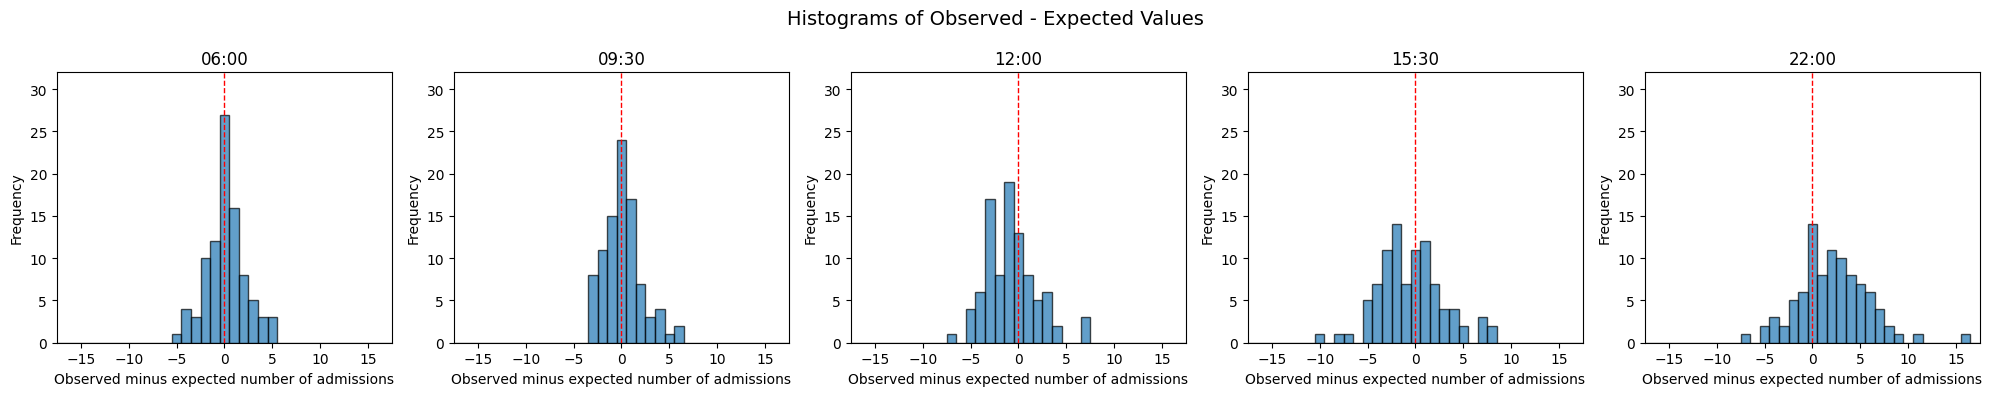

In [11]:
from patientflow.viz.evaluation_plots import plot_observed_against_expected
plot_observed_against_expected(results)

Fro the plots above: 
* The 06:00 and 09:30 models data shows a slight positive bias, with more values above zero than below, suggesting under-prediction (observed values higher than expected)
* The 12:00 model appears more spread out with a wider range of error
* The 15:30 model has a slight negative bias
* The 22:00 time slot displays a distinct positive skew, with most values above zero, suggesting consistent under-prediction

### QQ (quantile-quantile) Plots

A QQ plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients in each group snapshot who were later admitted. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 

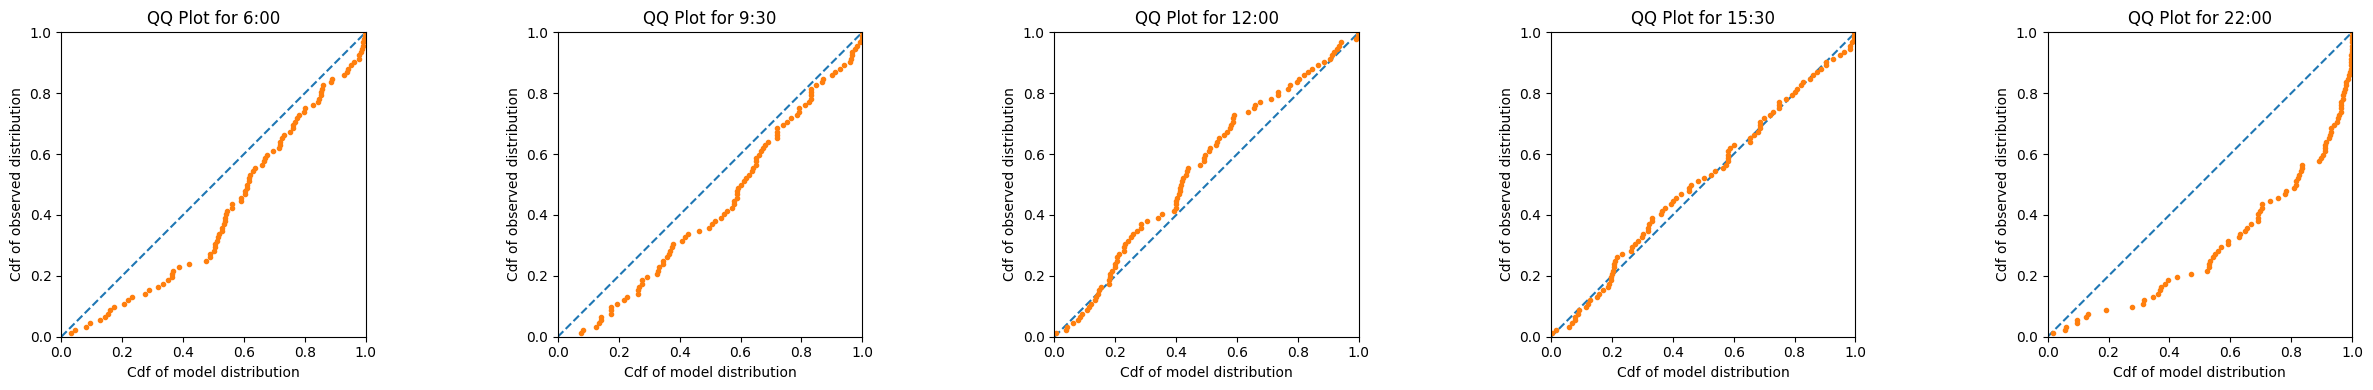

In [9]:
from patientflow.viz.qq_plot import qq_plot

qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions")

The 12:00 distributions show the closest adherence to the predicted distribution (closest to the diagonal line). The 06:00 and 09:30 deviate in the middle range, suggesting some bias in predictions, and the 22:00 QQ plot shows significant deviation. From an [earlier notebook](2c_Evaluate_patient_snapshot_models.ipynb), we know that the 09:30 and 22:00 admissions models both slightly underestimate each patient's probability of admission. We see this underestimate being propogated here; for both prediction times the points fall below the y=x line. However the 22:00 points fall substantially below; the observed values deviate markedly at the lower end of the distribution. More patients are being admitted than the model expects. 

However, QQ plots can be problematic when used with discrete distributions. In a discrete distribution, probability mass is assigned in 'chunks' to each discrete value, which makes certain regions of the QQ plot impossible. 

Over larger ranges this problem is less marked, because the observed values fall on a greater variety of points on their predicted distributions. However, if the numbers are small (for example if there are two children in the ED, possible values for the predicted distribution will be 0, 1 or 2), the integer nature of a discrete distribution is very marked. Observed values for these small ranges tend to fall at the same points on their predicted distributions, creating a staircase effect in the QQ plot. We will see this when we start making predictions by subplots in the following notebooks.

## Adjusted QQ plot

We handle the discrete nature of the predicted distribution in a Adjusted QQ plot. This approach was used in prior work evaluating a tool to predict short term demand for beds in an intensive care unit. See Figure 9 in [Pagel et al (2017)](https://www.sciencedirect.com/science/article/pii/S2211692316300418).

When mapping an observed value to its is Cumulative Distribution Function (CDF), there is an arbitrary choice as to whether to read the lower or upper value of the CDF at that point, or the mid point between the two. The QQ plots above use the mid point. 

In the Adjusted QQ Plot the x axis represents the CDF from the model's predictions and the y axis represents the proportion of observed values that fall below that threshold. For the observed values, there are three CDFs shown on the plot (in colour) and for the model there are three (in grey)

* The lower CDF at a point is the sum of probabilities for all values less than that value
* The upper CDF at a point is the sum of probabilities for all values less than or equal to that value
* The mid CDF is the average of upper and lower

If the observed cdf points track the model cdfs, the model performs well. 

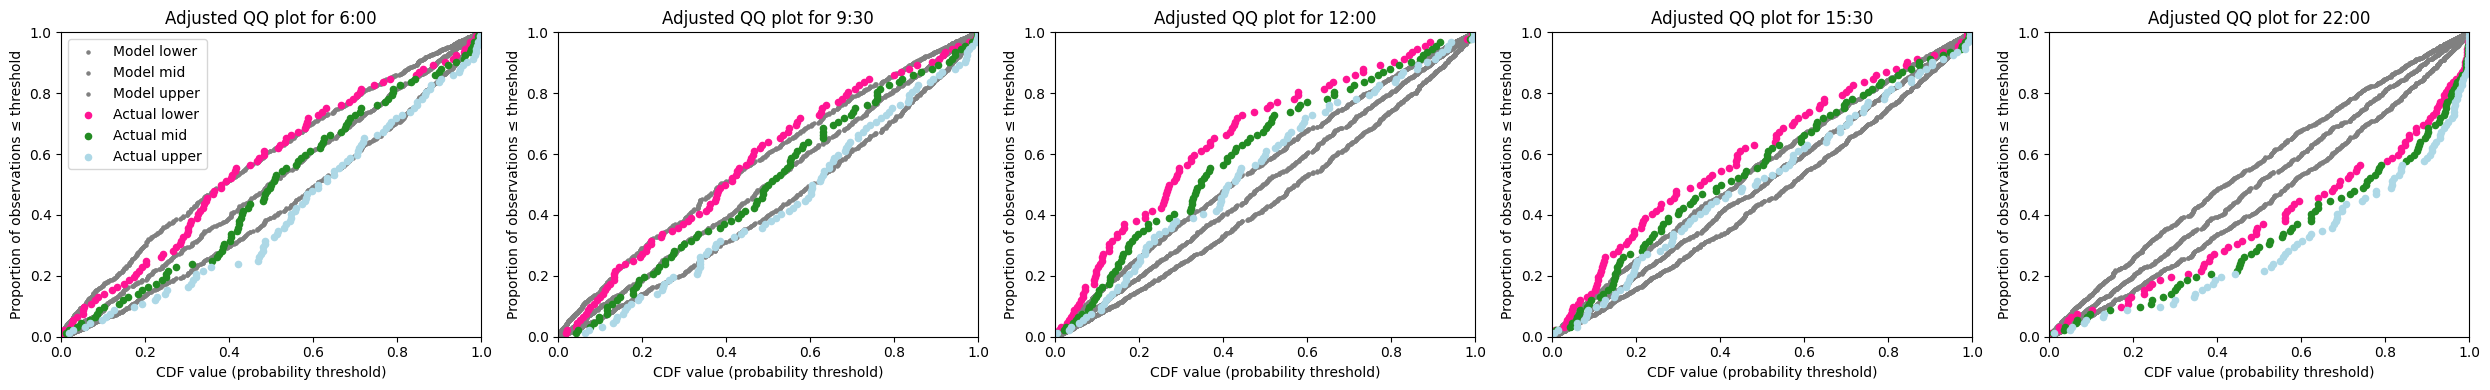

In [10]:
from patientflow.viz.adjusted_qq_plot import adjusted_qq_plot

adjusted_qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions")

In the plot above, the 06:00 and 09:30 models perform well. At 12:00 and 15:30 the predicted probabilities are consistently lower than the observed frequencies, and at 22:00 they are higher. At 22:00, more patients are being admitted than the model expects. 

There appears to be some bias introduded at the aggregation step, that has not been propogated through from the patient-level predictions. 

The Adjusted QQ Plot demonstrates that further work is needed to isolate the reason for this bias. 

## Conclusions

Here I have demonstrated some methods for evaluating predicted distributions, including summary statistics, QQ Plots and Adjusted QQ Plots.  

We prefer plots over summary statistics like MAE or MPE. Plots allow us to compare the predicted and observed distributions across the full probability range. This can be helpful for detecting issues in the tails of distributions. For instance, in the 22:00 time, the plot reveals deviations in the upper quantiles that summary statistics would obscure.

I noted above that plots for discrete distributions can be problematic, and demonstrated an Adjusted QQ plot that is designed to evaluate them. It helps to identify where in the modelling pipeline model bias is being introduced, and identify aspects that need to be investigated further. I will make use of this plot in later notebooks evaluating our emergency demand predictions by specialty. 
